### Load them libraries...

In [87]:
library(phyloseq)
library(ggplot2)
require(scales)
library(vegan)
library(readr)
library(data.table)
library(dplyr)
library(stats)
library(ggpubr)
library(dunn.test)

#### Read in Sho original phyloseq object

In [113]:
#Non-transformed OTU counts
ps.nt = readRDS("/home/holutz/projects/CAWS/phyloseq.rds") 

In [114]:
#New ps object with 2019 water data
ps2.nt = readRDS("/home/holutz/projects/CAWS/phyloseq2.rds")
#Transform ASV counts to relative abundance
ps2.t = ps2.nt %>%
     transform_sample_counts(function(x) x / sum(x))

#### Introduce some modifications to original phyloseq object

In [131]:
#Import phylogenetic information
tre = read_tree("/home/holutz/projects/CAWS/study_tree.tree")

#Import modified metadata w numeric variables as factors
map = import_qiime_sample_data("/home/holutz/projects/CAWS/Metadata_2019_corrected_water2.txt")
map$year_coll.factor = as.factor(map$year_coll.factor)
map$SITE_CODE.factor = as.factor(map$SITE_CODE.factor)
#map = sample_data(ps2.nt)

#breakdown ps.nt into components to create new phyloseq object
otu = otu_table(ps2.nt)
tax = tax_table(ps2.nt)

#create new phyloseq object by combining all of the above
ps.nt = merge_phyloseq(tre,map,otu,tax)

#Trasform ASVs for relative abundance within each library
ps.t = ps.nt %>%
    transform_sample_counts(function(x) x / sum(x))
                            
#Save new non-transformed and transformed phyloseq objects for subsequent analysis
saveRDS(ps.nt, "/home/holutz/projects/CAWS/CAWS_nt.2.rds")
saveRDS(ps.t, "/home/holutz/projects/CAWS/CAWS_t.2.rds")

### BEGIN ANALYSES HERE

In [6]:
#Read in phyloseq objects (ps)
ps.nt = readRDS("/home/holutz/projects/CAWS/CAWS_nt.2.rds")
ps.t = readRDS("/home/holutz/projects/CAWS/CAWS_t.2.rds")
#Display ps information
ps.t

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 50223 taxa and 832 samples ]
sample_data() Sample Data:       [ 832 samples by 42 sample variables ]
tax_table()   Taxonomy Table:    [ 50223 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 50223 tips and 50201 internal nodes ]

In [96]:
#Explore metadata as a dataframe
ps.df = data.frame(sample_data(ps.t))
colnames(ps.df)
head(ps.df$SITE_CODE.factor)

[1] "X.SampleID"          "SITE_CODE"           "SITE_CODE.factor"   
 [4] "Sample_type"         "SourceSink"          "Env"                
 [7] "kit"                 "Disinfection_status" "date_collected"     
[10] "year_coll.factor"    "year_collected"      "monthyear"          
[13] "season_collected"    "month_collected"     "Herbert"            
[16] "Weather"             "Location"            "Land_use"           
[19] "run_prefix"          "DO"                  "Temp"               
[22] "pH"                  "NO2_NO3"             "NH3_N"              
[25] "TOT_PHOS"            "SO4"                 "TDS"                
[28] "SS"                  "ALK"                 "Cl"                 
[31] "Fluorine"            "TOC"                 "FEC_COL"            
[34] "Chlorophyll"         "conductivity"        "Turbidity"          
[37] "Ref_to_WRP"          "Miles_from_WRP"      "Region"             
[40] "Region_type"         "Disinfection"        "Description"

[1] SiteCode_56 SiteCode_56 SiteCode_59 SiteCode_59 SiteCode_99 SiteCode_52
17 Levels: SiteCode_100 SiteCode_108 SiteCode_112 SiteCode_36 ... SiteCode_99

### Calculate betadiversity metrics for PCoA

#### Weighted and Unweighted UniFrac for all samples combined

In [125]:
#Wunif
#wunif.dist = distance(ps.t, method = "wunifrac", type = "samples")
#wunif.dist.log = ordinate(ps.t, method = "PCoA", distance = "wunifrac")
#wunif.dist.evals = wunif.dist.log$values$Eigenvalues

#Save estimates so you don't have to rerun every time
#saveRDS(wunif.dist, "/home/holutz/projects/CAWS/wunifrac/wunif.ps2.dist.rds")
#saveRDS(wunif.dist.log, "/home/holutz/projects/CAWS/wunifrac/wunif.ps2.dist.log.rds")
#saveRDS(wunif.dist.evals, "/home/holutz/projects/CAWS/wunifrac/wunif.ps2.dist.evals.rds")

In [137]:
#Unif

#unif.dist = distance(ps.t, method = "unifrac", type = "samples")
#unif.dist.log = ordinate(ps.t, method = "PCoA", distance = "unifrac")
#unif.dist.evals = unif.dist.log$values$Eigenvalues

#Save estimates so you don't have to rerun every time
#saveRDS(unif.dist, "/home/holutz/projects/CAWS/unifrac/unif.ps2.dist.rds")
#saveRDS(unif.dist.log, "/home/holutz/projects/CAWS/unifrac/unif.ps2.dist.log.rds")
#saveRDS(unif.dist.evals, "/home/holutz/projects/CAWS/unifrac/unif.ps2.dist.evals.rds")

In [142]:
#Read in saved distance metrics for plotting and statistical analysis
#Weighted UniFrac
wunif.dist = readRDS("/home/holutz/projects/CAWS/wunifrac/wunif.ps2.dist.rds")
wunif.dist.log = readRDS("/home/holutz/projects/CAWS/wunifrac/wunif.ps2.dist.log.rds")
wunif.dist.evals = readRDS("/home/holutz/projects/CAWS/wunifrac/wunif.ps2.dist.evals.rds")

#Unweighted UniFrac
unif.dist = readRDS("/home/holutz/projects/CAWS/unifrac/unif.ps2.dist.rds")
unif.dist.log = readRDS("/home/holutz/projects/CAWS/unifrac/unif.ps2.dist.log.rds")
unif.dist.evals = readRDS("/home/holutz/projects/CAWS/unifrac/unif.ps2.dist.evals.rds")

#### Plot PCoA

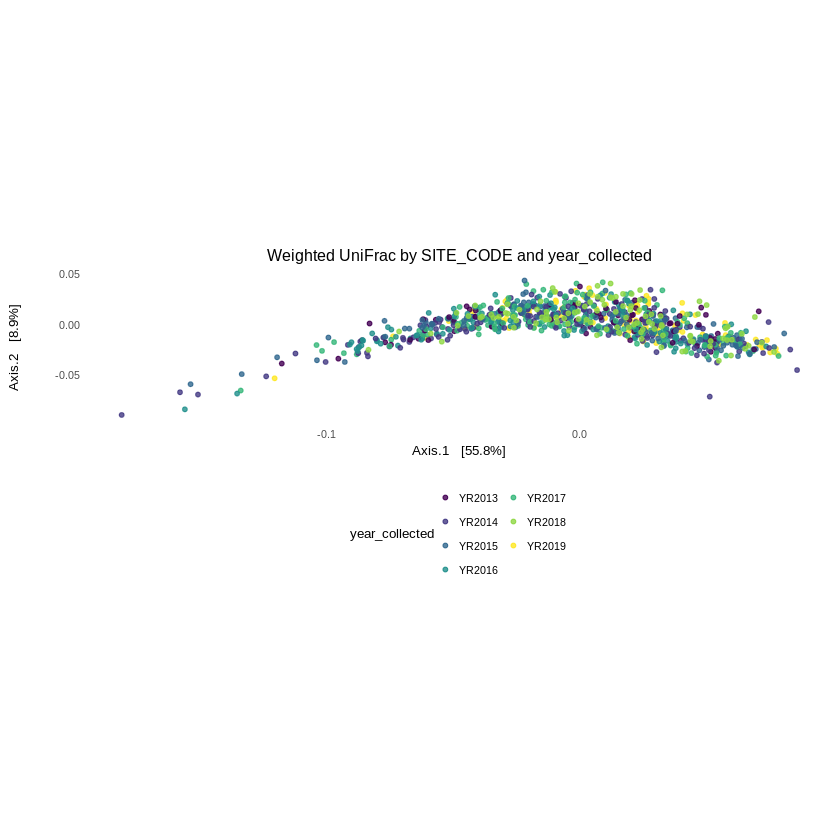

png 
  2

png 
  2

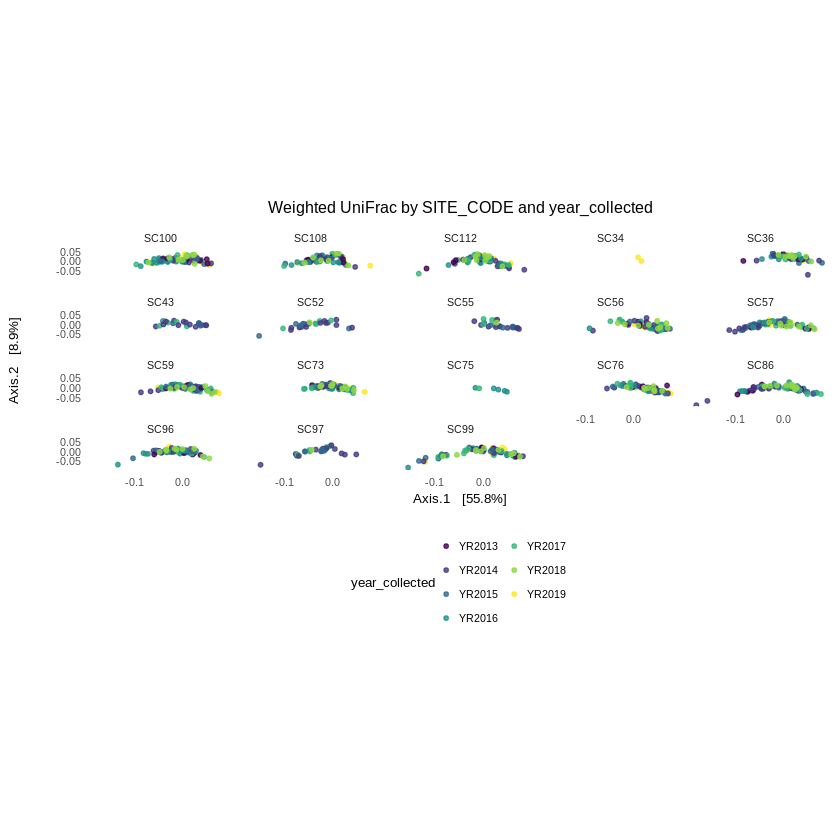

In [140]:
library(viridis)

p = plot_ordination(ps.t, wunif.dist.log, color = "year_coll.factor") + #, shape = "SampleType", label="X.SampleID") + 
    ggtitle("Weighted UniFrac by SITE_CODE and year_collected") +
    geom_point(size=1, alpha=0.8) + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = year_collected), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=FALSE, direction=1)+
    coord_fixed(sqrt(wunif.dist.evals[2] / wunif.dist.evals[1]))

p = p + guides(colour = guide_legend(title = "year_collected", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_minimal() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              legend.key.size = unit(.1, "in"),
              legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom",
              plot.title = element_text(hjust = 0.5))

p$layers <- p$layers[-1]

p

p2 = p + facet_wrap(~SITE_CODE.factor)

p2

png('/home/holutz/projects/CAWS/wunifrac/wunif_by_year_v2.png', width=8, height=12, units='in', res=500)
plot(p)
dev.off()

png('/home/holutz/projects/CAWS/wunifrac/wunif_by_sitecode.facet_v2.png', width=8, height=8, units='in', res=500)
plot(p2)
dev.off()

In [143]:
sample_tab = data.frame(sample_data(ps.t))
head(sample_tab)

,X.SampleID,SITE_CODE,SITE_CODE.factor,Sample_type,SourceSink,Env,kit,Disinfection_status,date_collected,year_collected,⋯,Total_Length,Standard_Length,Weight,Sex,Final.Hg,FEC_COL_pre,Hg,Description,year_coll.factor.1,SITE_CODE.factor.1
,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<fct>,<int>,<int>
3773,3773,96,SC96,Water,NA,NA,NA,Post,9/9/19,2019,⋯,NA,NA,NA,NA,NA,NA,NA,,2019,96
3710,3710,99,SC99,Water,NA,NA,NA,Post,6/17/19,2019,⋯,NA,NA,NA,NA,NA,NA,NA,,2019,99
3581,3581,99,SC99,Water,NA,NA,NA,Post,3/18/19,2019,⋯,NA,NA,NA,NA,NA,NA,NA,,2019,99
3703,3703,96,SC96,Water,NA,NA,NA,Post,6/10/19,2019,⋯,NA,NA,NA,NA,NA,NA,NA,,2019,96
3621,3621,34,SC34,Water,NA,NA,NA,Post,5/1/19,2019,⋯,NA,NA,NA,NA,NA,NA,NA,,2019,34
3781,3781,86,SC86,Water,NA,NA,NA,Post,9/23/19,2019,⋯,NA,NA,NA,NA,NA,NA,NA,,2019,86


In [165]:
#Estimate betadispersion - weighted unifrac
beta.disp.wuf = betadisper(wunif.dist,group = sample_data(ps.t)$SITE_CODE.factor)
beta.disp.wuf = beta.disp.wuf$distances
beta.disp.wuf = data.frame(d = beta.disp.wuf, X.SampleID = names(beta.disp.wuf)) #The "X." in SampleID is introduced because of the # sign in the metadata
beta.disp.wuf2 = left_join(beta.disp.wuf, sample_tab, by="X.SampleID")

In [180]:
kruskal.test(d~SITE_CODE.factor, data=beta.disp.wuf2)

krusk.wuf = dunn.test(beta.disp.wuf2$d, beta.disp.wuf2$SITE_CODE.factor, method = "Bonferroni")
write.table(krusk.wuf, "/home/holutz/projects/CAWS/unifrac/kw.wuf.bdisp.txt", sep="\t")


	Kruskal-Wallis rank sum test

data:  d by SITE_CODE.factor
Kruskal-Wallis chi-squared = 155.41, df = 17, p-value < 2.2e-16


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 155.412, df = 17, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |      SC100      SC108      SC112       SC34       SC36       SC43
---------+------------------------------------------------------------------
   SC108 |  -1.666786
         |     1.0000
         |
   SC112 |  -0.359618   1.290544
         |     1.0000     1.0000
         |
    SC34 |   1.641248   2.052470   1.728225
         |     1.0000     1.0000     1.0000
         |
    SC36 |   0.358727   2.022760   0.713962  -1.554910
         |     1.0000     1.0000     1.0000     1.0000
         |
    SC43 |   1.229685   2.426420   1.480074  -1.194014   0.974632
         |     1.0000     1.0000     1.0000     1.0000     1.0000
         |
    SC52 |   0.197260   1.460813   0.467707  -1.543085  -0.071576  -0

In [166]:
avg_obs <- aggregate(d ~ SITE_CODE.factor, data = beta.disp.wuf2, mean)
beta.disp.wuf2$SITE_CODE.factor <-factor(beta.disp.wuf2$SITE_CODE.factor, levels=avg_obs[order(avg_obs$d), "SITE_CODE.factor"])

png 
  2

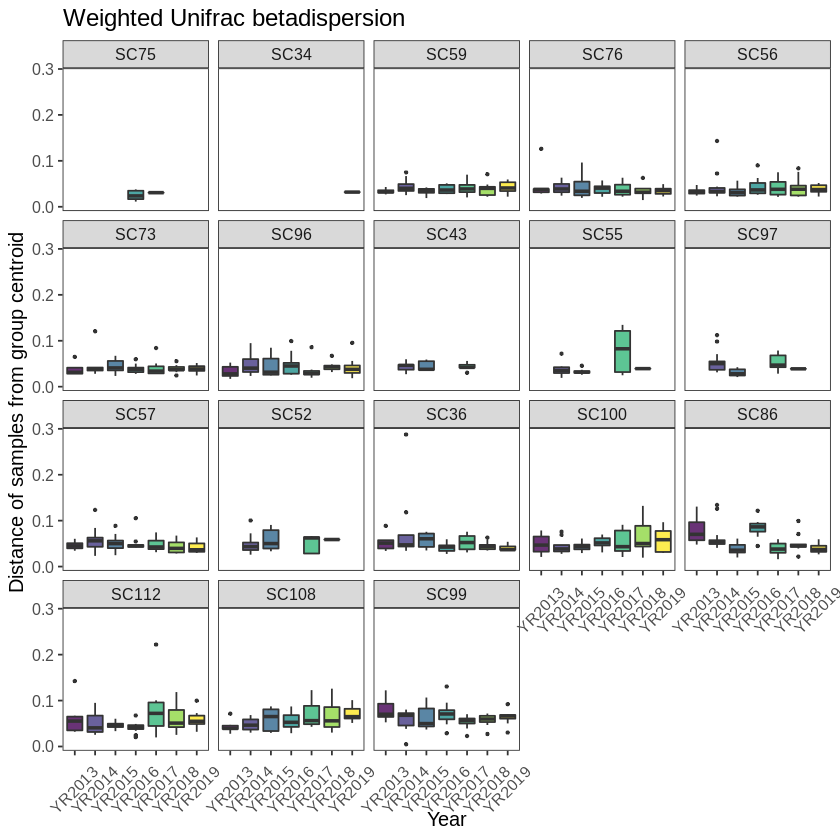

In [182]:
p = ggplot(beta.disp.wuf2, aes(x = year_coll.factor, y = d, fill = year_coll.factor)) + ggtitle("Weighted Unifrac betadispersion")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Year") #+ 
        #scale_y_continuous(limits=c(0,0.2))
        #coord_flip(ylim = c(0,1))

p = p + scale_fill_viridis(discrete=TRUE, alpha=0.8)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.text.x=element_text(angle=45,vjust=0.4))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#p = p + geom_hline(yintercept = 0.1975)
p = p + facet_wrap(~SITE_CODE.factor)

p

png('/home/holutz/projects/CAWS/wunifrac/wunif.bdisp.year_by_site.png', width=8, height=8, units='in', res=500)
plot(p)
dev.off()

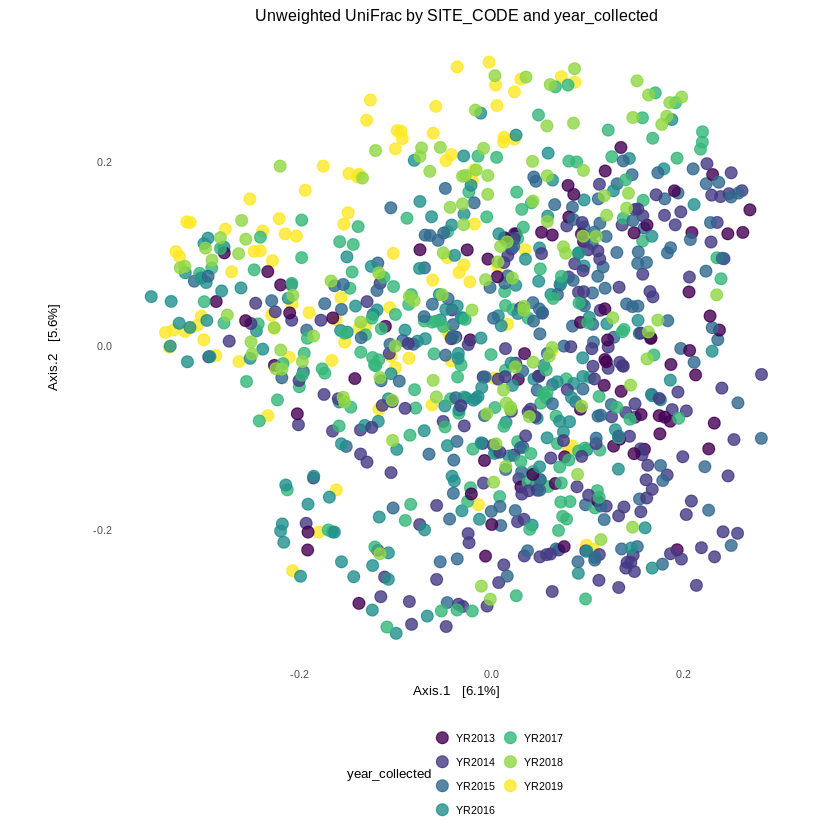

png 
  2

png 
  2

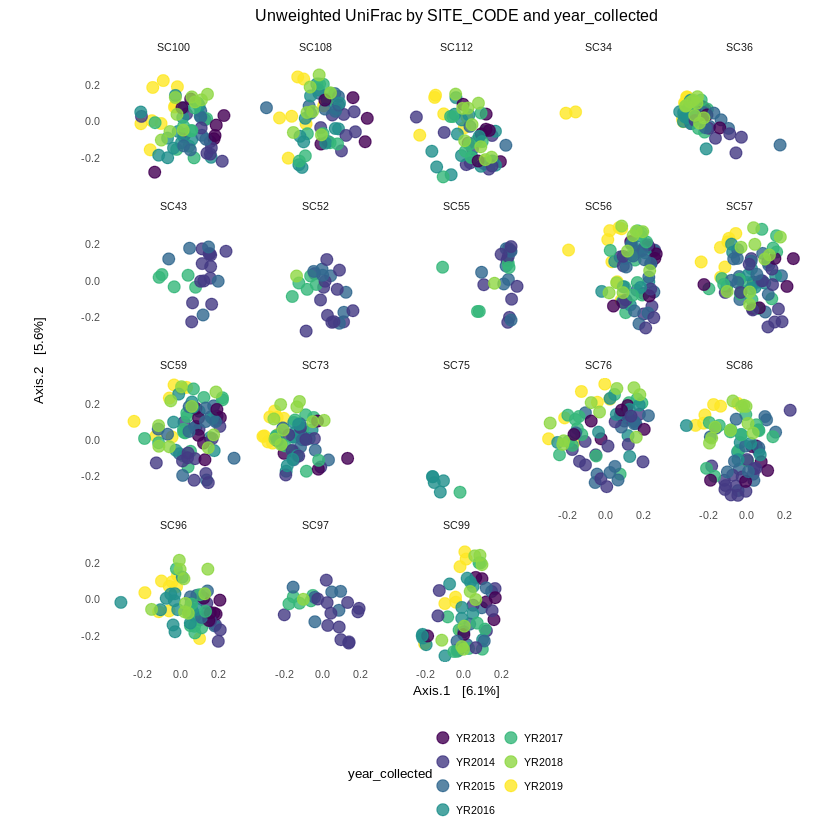

In [139]:
library(viridis)

p = plot_ordination(ps.t, unif.dist.log, color = "year_coll.factor") + #, shape = "SampleType", label="X.SampleID") + 
    ggtitle("Unweighted UniFrac by SITE_CODE and year_collected") +
    geom_point(size=3, alpha=0.8) + 
    scale_colour_viridis(option="viridis", discrete=TRUE, direction=1) +
    #stat_ellipse(level=0.95, geom="polygon",alpha = .2, aes(fill = year_collected), linetype=0) +
    #scale_fill_viridis(option="viridis", discrete=FALSE, direction=1)+
    coord_fixed(sqrt(unif.dist.evals[2] / unif.dist.evals[1]))

p = p + guides(colour = guide_legend(title = "year_collected", ncol = 2, keywidth = 1, keyheight = 1))

p = p + theme_minimal() + 
        theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=8, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.ticks = element_blank(),
              legend.key.size = unit(.1, "in"),
              legend.spacing.x = unit(.01,"in"),
              legend.position = "bottom",
              plot.title = element_text(hjust = 0.5))

p$layers <- p$layers[-1]

p

p2 = p + facet_wrap(~SITE_CODE.factor)

p2

png('/home/holutz/projects/CAWS/unifrac/unif_by_year_v2.png', width=8, height=8, units='in', res=500)
plot(p)
dev.off()

png('/home/holutz/projects/CAWS/unifrac/unif_by_sitecode.facet_v2.png', width=8, height=8, units='in', res=500)
plot(p2)
dev.off()

In [169]:
#Estimate betadispersion - eighted unifrac
beta.disp.uf = betadisper(unif.dist,group = sample_data(ps.t)$SITE_CODE.factor)
beta.disp.uf = beta.disp.uf$distances
beta.disp.uf = data.frame(d = beta.disp.uf, X.SampleID = names(beta.disp.uf))
beta.disp.uf2 = left_join(beta.disp.uf, sample_tab, by="X.SampleID")

In [179]:
kruskal.test(d~year_coll.factor, data=beta.disp.uf2)

krusk.uf = dunn.test(beta.disp.uf2$d, beta.disp.uf2$year_coll.factor, method = "Bonferroni")
write.table(krusk.uf, "/home/holutz/projects/CAWS/unifrac/kw.uf.bdisp.txt", sep="\t")


	Kruskal-Wallis rank sum test

data:  d by year_coll.factor
Kruskal-Wallis chi-squared = 47.936, df = 6, p-value = 1.217e-08


  Kruskal-Wallis rank sum test

data: x and group
Kruskal-Wallis chi-squared = 47.9359, df = 6, p-value = 0


                           Comparison of x by group                            
                                 (Bonferroni)                                  
Col Mean-|
Row Mean |     YR2013     YR2014     YR2015     YR2016     YR2017     YR2018
---------+------------------------------------------------------------------
  YR2014 |  -1.378688
         |     1.0000
         |
  YR2015 |   0.151936   1.902153
         |     1.0000     0.6001
         |
  YR2016 |  -2.577716  -1.569486  -3.326786
         |     0.1044     1.0000    0.0092*
         |
  YR2017 |  -3.540567  -2.784956  -4.530136  -1.127399
         |    0.0042*     0.0562    0.0001*     1.0000
         |
  YR2018 |  -2.609084  -1.649962  -3.271226  -0.202871   0.832401
         |     0.0953     1.0000    0.0112*     1.0000     1.0000
         |
  YR2019 |  -4.603495  -4.078960  -5.572175  -2.602677  -1.642558  -2.

In [170]:
#This code will arrange your values by the mean betadispersion so the boxplots look nice; 
#Need to be careful if color codes matter, may want to manually color if so
avg_obs <- aggregate(d ~ SITE_CODE.factor, data = beta.disp.uf2, mean)
beta.disp.uf2$SITE_CODE.factor <-factor(beta.disp.uf2$SITE_CODE.factor, levels=avg_obs[order(avg_obs$d), "SITE_CODE.factor"])

png 
  2

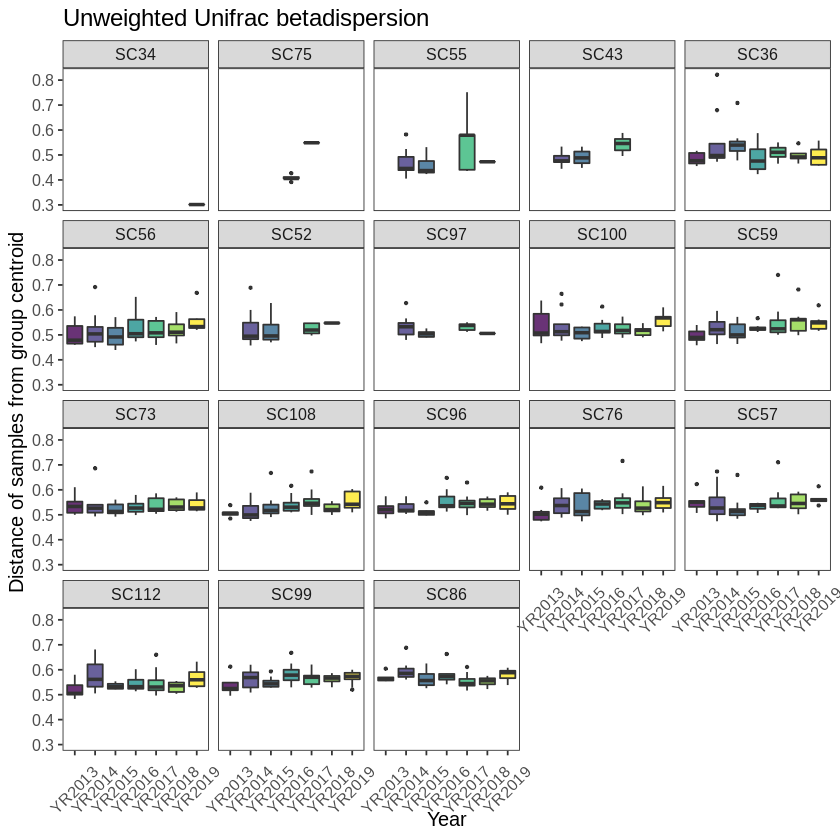

In [181]:
p = ggplot(beta.disp.uf2, aes(x = year_coll.factor, y = d, fill = year_coll.factor)) + ggtitle("Unweighted Unifrac betadispersion")

p = p + geom_boxplot(outlier.stroke = 0.2, outlier.shape=20) + 
        ylab("Distance of samples from group centroid ") + 
        xlab("Year") #+ 
        #scale_y_continuous(limits=c(0,0.2))
        #coord_flip(ylim = c(0,1))

p = p + scale_fill_viridis(discrete=TRUE, alpha=0.8)

p = p + theme_bw() + theme(text=element_text(size=12, color="black",family = "Arial"),
                           legend.key = element_blank(),
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(),
                           legend.position="none",
                           axis.text.x=element_text(angle=45,vjust=0.4))
                           #axis.title.x=element_blank(),
                           #axis.title.y=element_text(margin=margin(0,10,0,0)))

#p = p + geom_hline(yintercept = 0.1975)
p = p + facet_wrap(~SITE_CODE.factor)

p

png('/home/holutz/projects/CAWS/unifrac/unif.bdisp.year_by_site.png', width=8, height=8, units='in', res=500)
plot(p)
dev.off()

#### Plotting fecal coliform data for Fig.X

In [24]:
fc = read.csv("/home/holutz/projects/CAWS/FC_data/FC_Figure_Data.csv")
fc$date.collected = as.Date(fc$date.collected, format = "%m/%d/%Y")

In [82]:
head(fc)
tail(fc)

,CAWS.,LIMS.,Site,date.collected,FEC.COL_CFU
,<fct>,<fct>,<fct>,<date>,<int>
1,221,6859117,OB,2013-05-14,5500
2,#N/A,6876034,OB,2013-06-04,24000
3,182,6880799,OB,2013-06-11,9800
4,209,6886600,OB,2013-06-18,8800
5,222,6891959,OB,2013-06-25,21000
6,164,6897267,OB,2013-07-02,11000


,CAWS.,LIMS.,Site,date.collected,FEC.COL_CFU
,<fct>,<fct>,<fct>,<date>,<int>
276,3698,8485065,CA,2019-05-28,40
277,3717,8504745,CA,2019-06-24,5
278,3737,8525070,CA,2019-07-22,90
279,3757,8550720,CA,2019-08-26,30
280,3807,8597145,CA,2019-10-28,60
281,3832,8616661,CA,2019-11-25,5


Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”


png 
  2

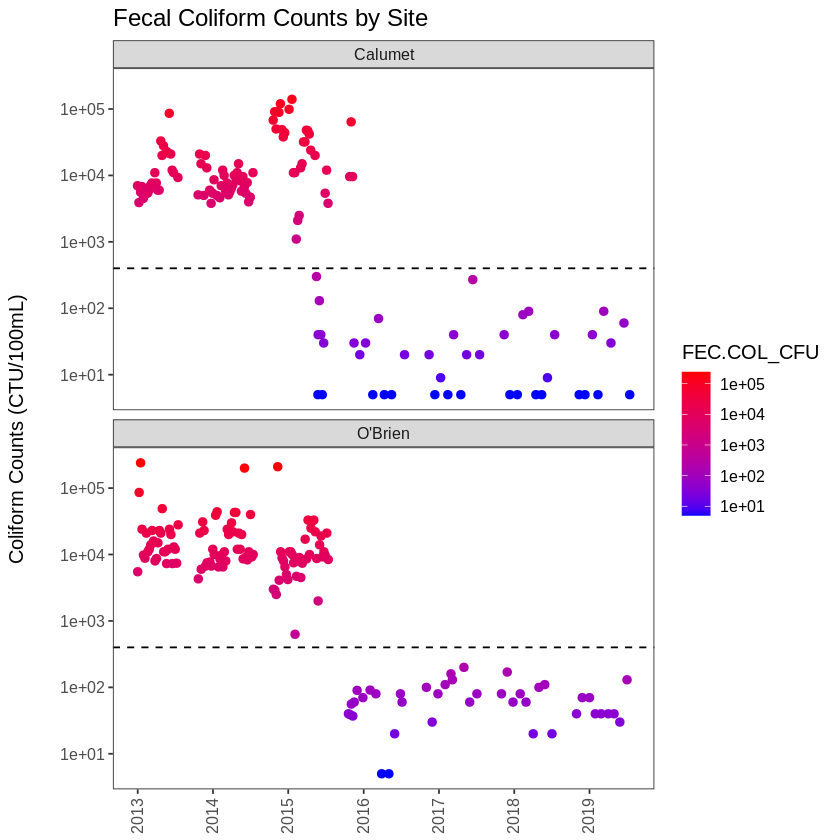

In [105]:
site.labs <- c("Calumet", "O'Brien")
names(site.labs) <- c("CA", "OB")
h <- 400

p = ggplot(fc, aes(x = date.collected, y = FEC.COL_CFU, color = FEC.COL_CFU)) + ggtitle("Fecal Coliform Counts by Site")
p = p + geom_point(size = 2) + 
        ylab("Coliform Counts (CTU/100mL)") +
        scale_y_continuous(trans='log10') +
        geom_hline(yintercept=400,linetype="dashed") +
        scale_color_gradient(trans="log10",low="blue",high="red")

p = p + theme_bw() + theme(panel.grid.major = element_blank(),
              axis.title.y=element_text(margin=margin(0,20,0,0)),
              text=element_text(size=12, color="black",family="Arial"),
              panel.grid.minor = element_blank(),
              #axis.text.x = element_blank(),
              #axis.ticks = element_blank(),
              axis.text.x=element_text(angle=90,vjust=0.4),
              #legend.key.size = unit(.25, "mm"),
              #legend.spacing.x = unit(.2,"in"),
              legend.position = "right",
              axis.title.x=element_blank())

p = p + scale_x_date(breaks = seq(as.Date("2013-05-14"), as.Date("2019-11-25"), by="1 year"),labels=date_format("%Y"))

p = p + facet_wrap(~Site, nrow=2,labeller = labeller(Site = site.labs))

p

png('/home/holutz/projects/CAWS/FC_data/FC_plot_gradient.png', width=12, height=8, units='in', res=300)
plot(p)
dev.off()